See [documentation](https://alleninstitute.github.io/sourcesep/00_simulations.html) for the generative model

TODO:
 - [x] Combine $\varepsilon(\lambda)$ and $l(\lambda)$ terms in absorbance
 - [ ] Add Autofluorescence term (maybe fit this) - Smrithi has this
 - [ ] convolve signal with 14 nm wide window along $\lambda$ dim; corresponds to slit image. 
 - [ ] include Poisson noise after the convolution step
 - [ ] include constant B (fiber fluorescence) term - Smrithi has this
 - [ ] motion term (dims signal)

```toml
# relative amplitude suggestions from Smrithi/Kaspar
[amplitude] 
A_fast = 1
A_slow = 0.2        # indicator dependent
B = 5               # fiber fluorescence
M = 1               # motion
N = 0.5             # laser noise
H_total_range = 0.1 # 0.05 around 1
f_range = 0.2       # 0.1 around 0.7
```



In [1]:
# Testing simulation class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
from rich import print as pprint
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

from sourcesep.sim import SimData
from sourcesep.utils.config import load_config

paths = load_config(dataset_key='all')
sim = SimData(T=1000, cfg_path=paths['root'] / "sim_config.toml")

Paths are for dataset tagged: all
Paths are for dataset tagged: all


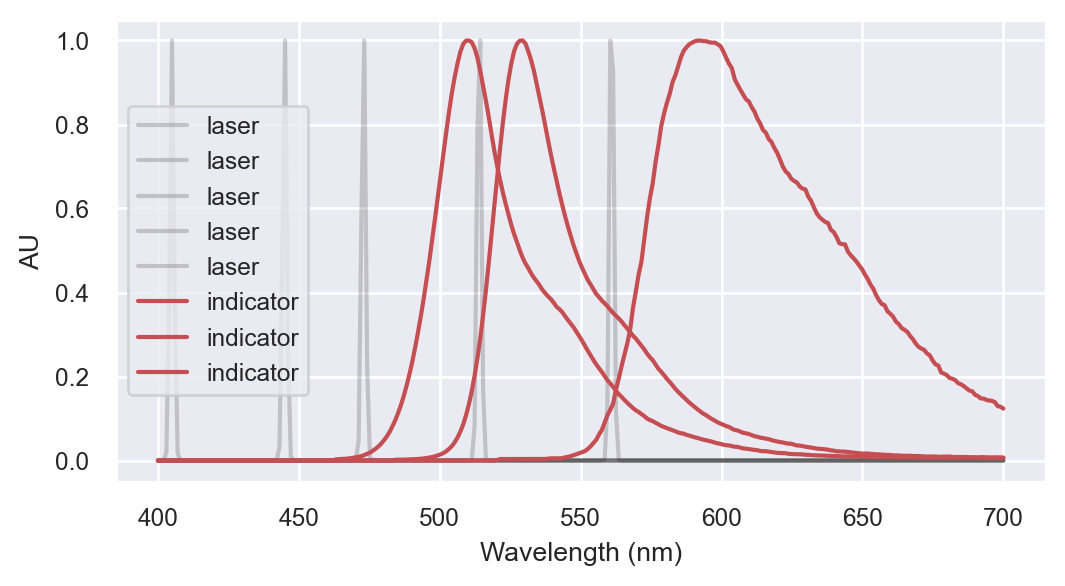

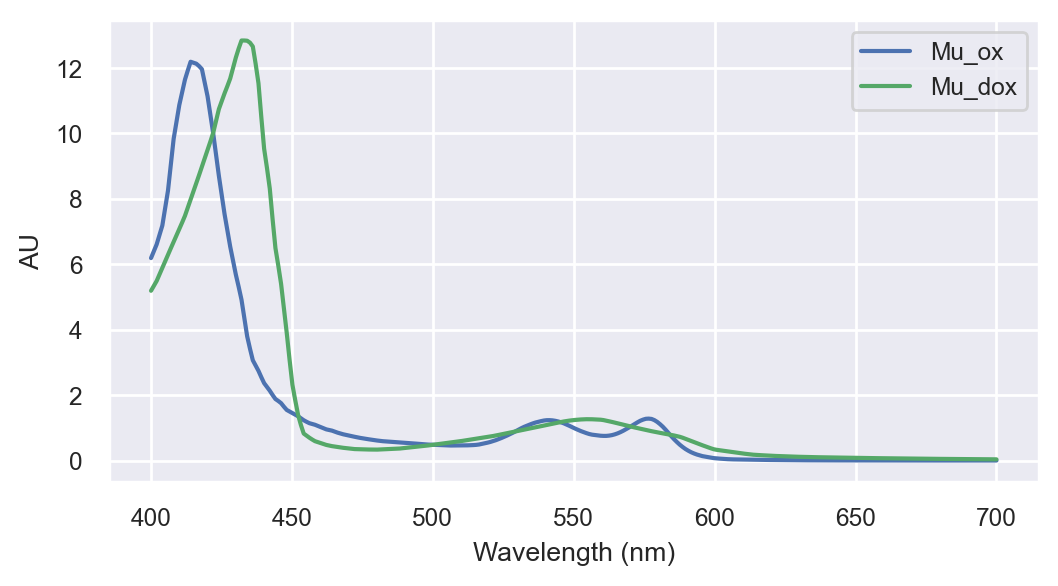

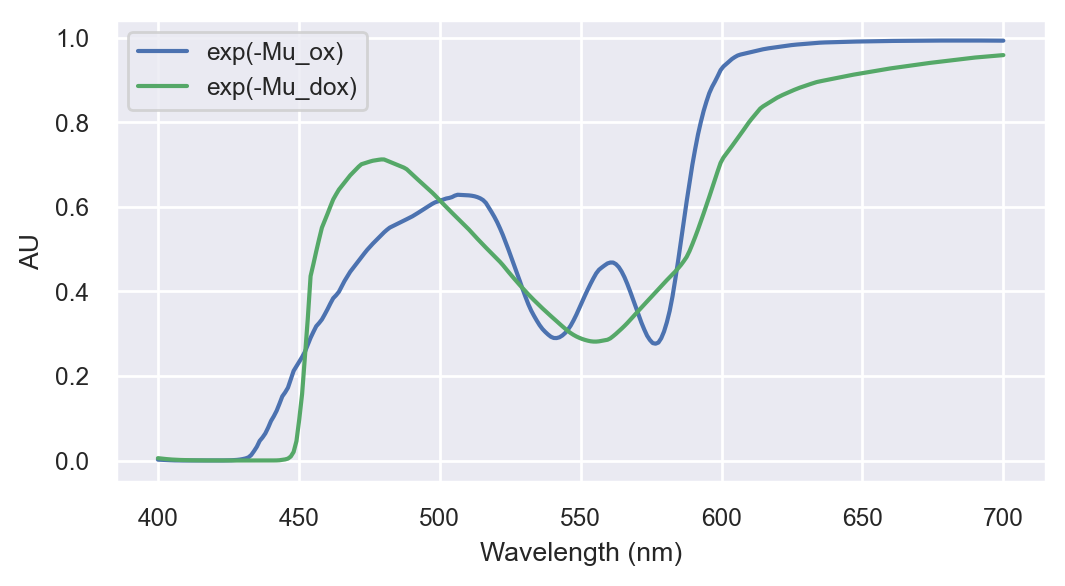

In [2]:
# indicator spectra S
# laser spectra E
# hemoglobin spectra Mu_ox, Mu_dox

S = sim.get_S()
W = sim.get_W()
E = sim.get_E()
Mu_ox, Mu_dox = sim.get_Mu()

f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, sim.E.T,'k', alpha=0.2, label='laser')
ax.plot(sim.L_arr, sim.S.T,'r', label='indicator')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, sim.Mu_ox, 'b',label='Mu_ox')
ax.plot(sim.L_arr, sim.Mu_dox, 'g',label='Mu_dox')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()


f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, np.exp(-1*sim.Mu_ox), 'b',label='exp(-Mu_ox)')
ax.plot(sim.L_arr, np.exp(-1*sim.Mu_dox), 'g',label='exp(-Mu_dox)')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()

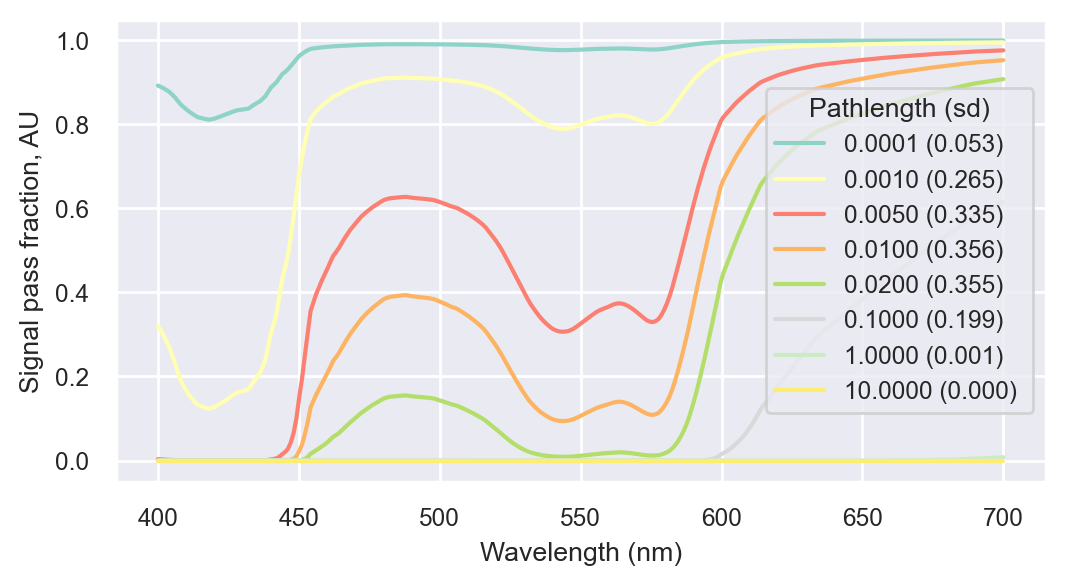

In [3]:
# The hemodynamic term attenuates the signal by a factor of exp(- (Mu_dox * H_dox + Mu_ox * H_ox))
# H_ox and H_dox sum up to roughly 1 at all time points
# Mu_ox and Mu_dox terms contain a heuristically set pathlength (see docs, modeling hemodynamics section)
# pathlength is set to roughly maximize variation (across wavelengths) in the [0,1] range

pathlength = sim.cfg['hemodynamics']['pathlength']

cmap = plt.get_cmap('Set3', lut=8)
f, ax = plt.subplots(figsize=(6,3))
for i, multiplier in enumerate([0.01, 0.1, 0.5, 1, 2, 10, 100, 1000]):
    y = np.exp(-multiplier*sim.Mu_dox - multiplier*sim.Mu_ox)
    ax.plot(sim.L_arr, y, '-' ,c=cmap(i), label=f'{multiplier*pathlength:0.4f} ({np.std(y):0.3f}) ')
ax.set(xlabel='Wavelength (nm)', ylabel='Signal pass fraction, AU')
plt.legend(title='Pathlength (sd)')
plt.show()


In [4]:
# emission efficiency W
pprint(sim.W_df)

405     445     473     514     561
EGFP    0.1732  0.3915  0.8143  0.1469  0.0043
Venus   0.0572  0.0505  0.2174  1.0000  0.0000
mApple  0.0069  0.0294  0.0920  0.3863  0.8972

activity generation took 834.85ms


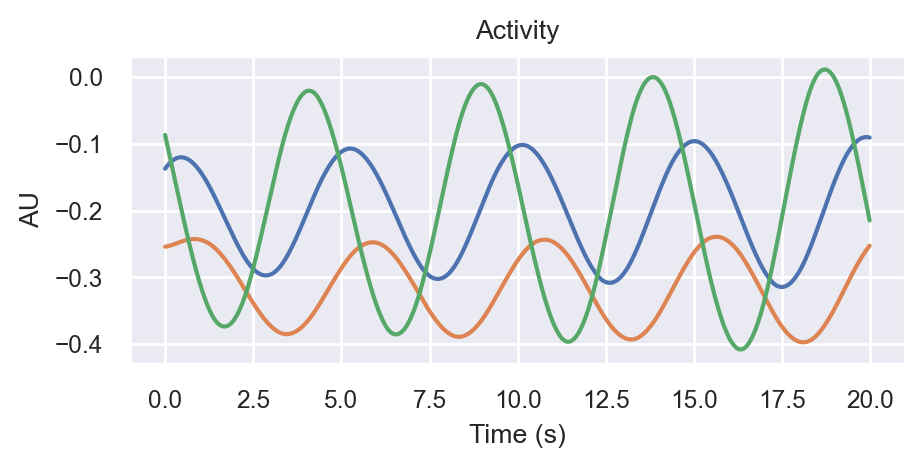

In [5]:
# example activity trace
with timebudget('activity generation'):
    A = sim.gen_A_slow()

_, ax = plt.subplots(figsize=(5,2))
plt.plot(sim.T_arr, A)
ax.set(xlabel='Time (s)', ylabel='AU', title='Activity')
plt.show()

In [6]:
# sample generation time cost
for i in range(10):
    with timebudget('20s sample (1k points)'):
        dat = sim.compose()

20s sample (1k points) took 127.61ms
20s sample (1k points) took 108.37ms
20s sample (1k points) took 98.55ms
20s sample (1k points) took 94.48ms
20s sample (1k points) took 85.82ms
20s sample (1k points) took 103.76ms
20s sample (1k points) took 98.53ms
20s sample (1k points) took 93.11ms
20s sample (1k points) took 89.42ms
20s sample (1k points) took 97.55ms


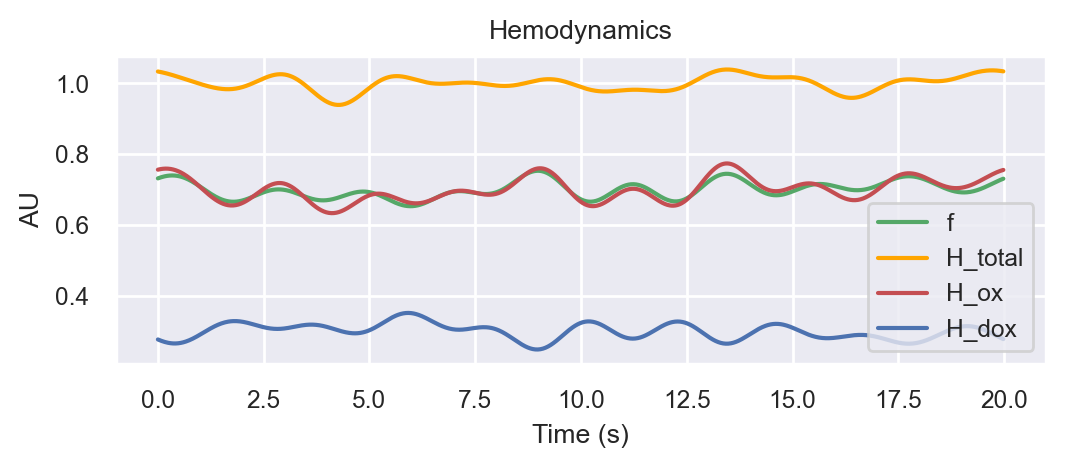

In [7]:
H_ox, H_dox, H_total, f = sim.gen_H()

fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(sim.T_arr, f, c='g', label='f')
ax.plot(sim.T_arr, H_total, c='orange', label='H_total')
ax.plot(sim.T_arr, H_ox, c='r', label='H_ox')
ax.plot(sim.T_arr, H_dox, c='b', label='H_dox')
ax.set(xlabel='Time (s)', ylabel='AU', title='Hemodynamics')
plt.legend()
plt.show()

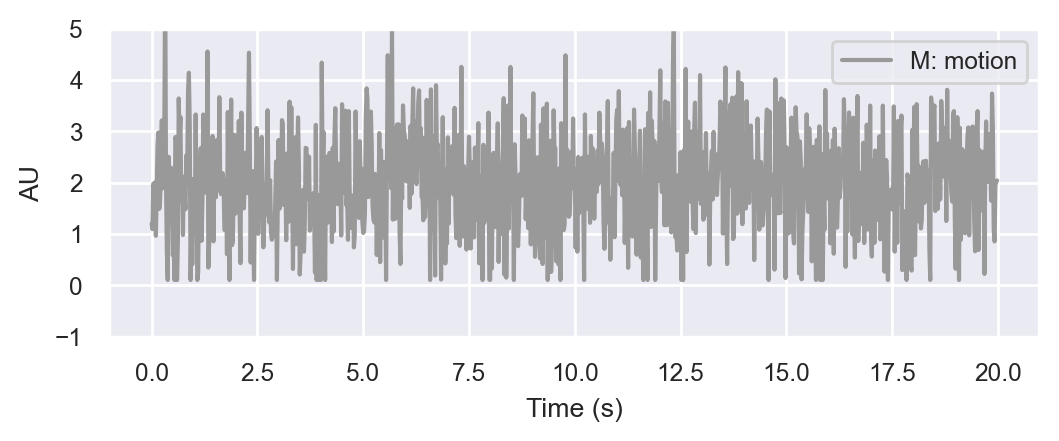

In [8]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['M'], c='#999999',label='M: motion')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[-1, 5])
plt.legend()
plt.show()

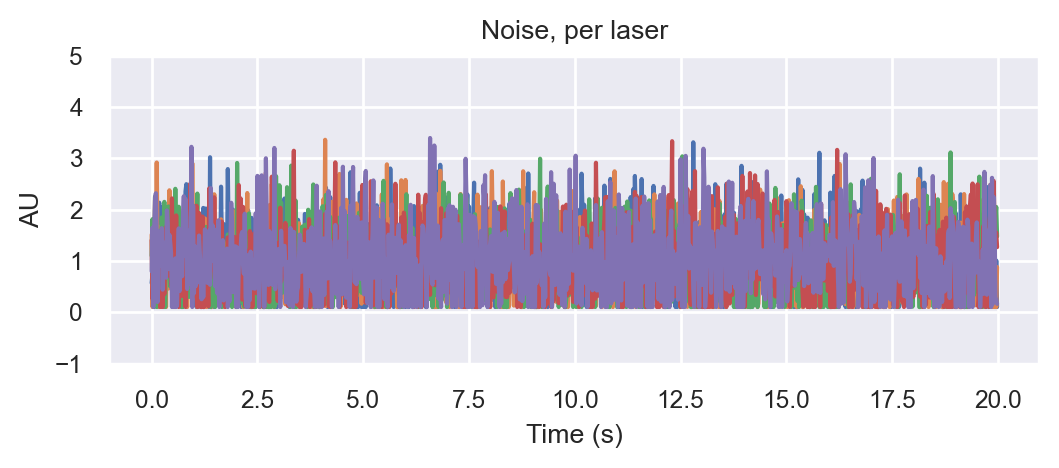

In [9]:
f, ax = plt.subplots(figsize=(6, 2))
ax.plot(sim.T_arr, dat['N'])
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[-1, 5], title='Noise, per laser')
plt.show()

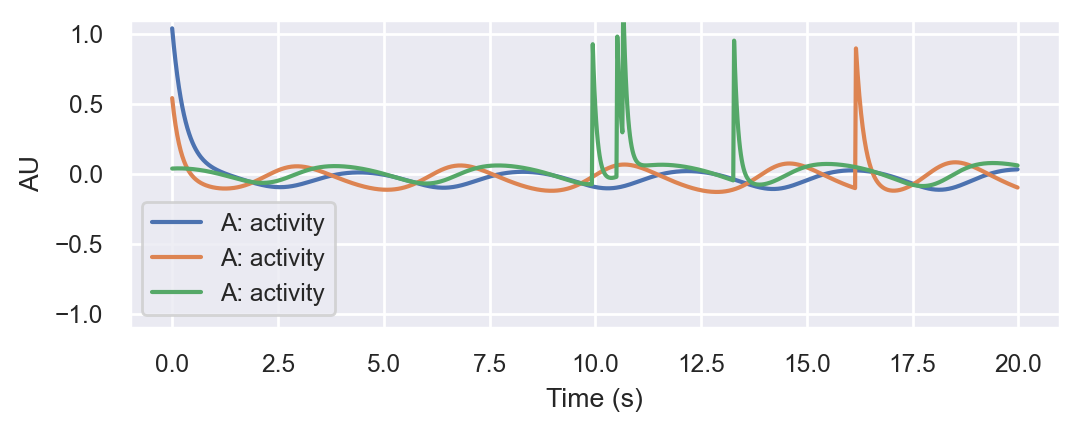

In [10]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['A'],label='A: activity')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[-1.1, 1.1])
plt.legend()
plt.show()

In [11]:
pprint(sim.cfg['indicator'].keys())
pprint(sim.cfg['laser'])
pprint(dat['O'].shape)

dict_keys(['EGFP', 'Venus', 'mApple'])

{
    'l0': {'em_wavelength_nm': 405},
    'l1': {'em_wavelength_nm': 445},
    'l2': {'em_wavelength_nm': 473},
    'l3': {'em_wavelength_nm': 514},
    'l4': {'em_wavelength_nm': 561}
}

(1000, 5, 300)

110


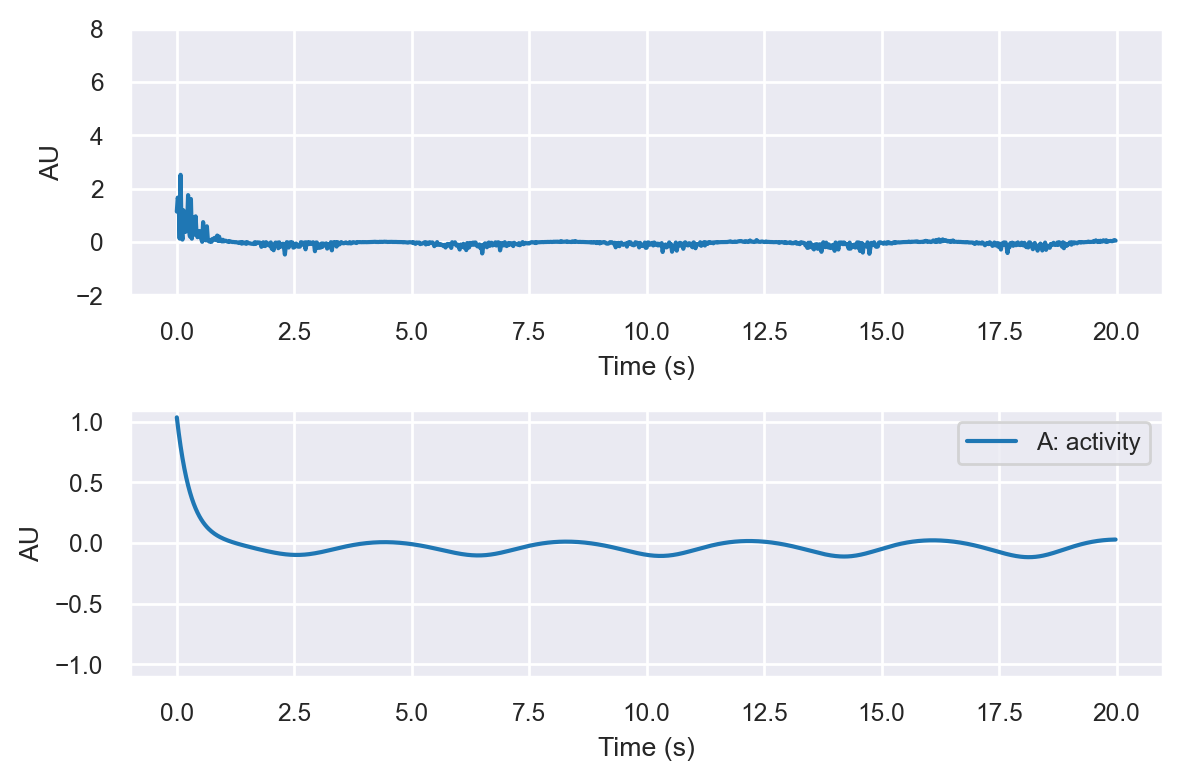

125


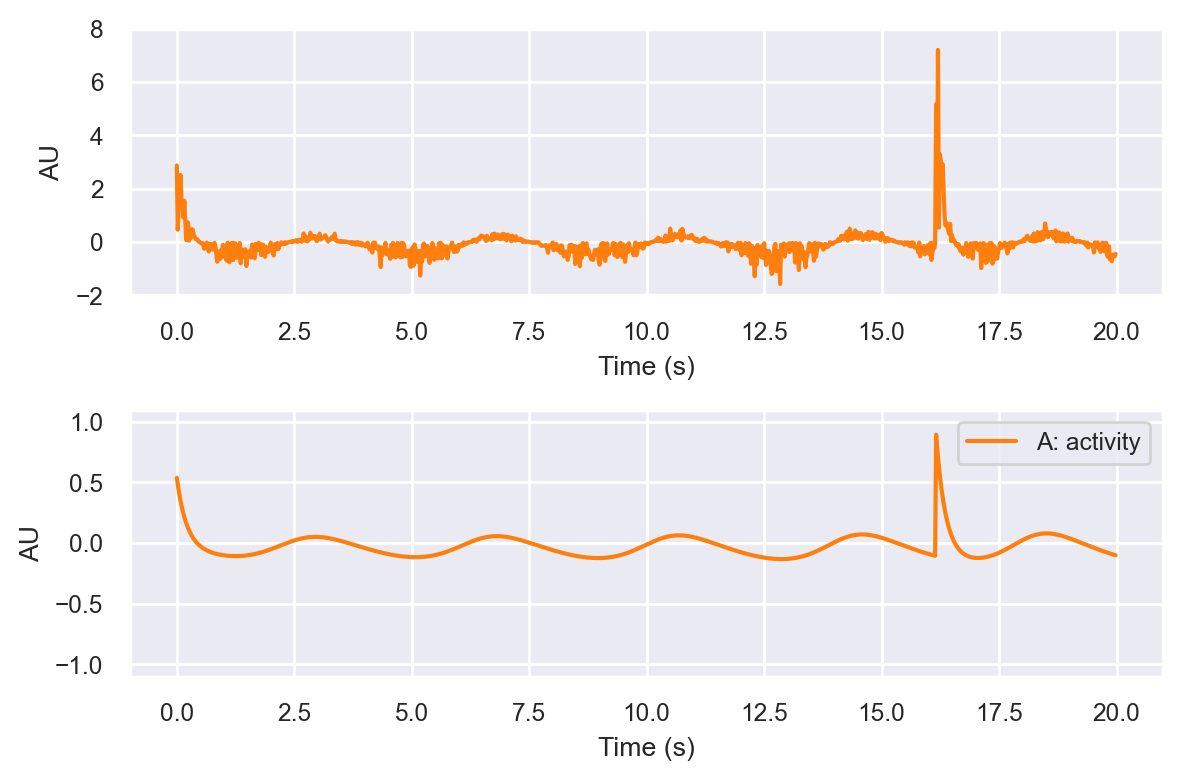

190


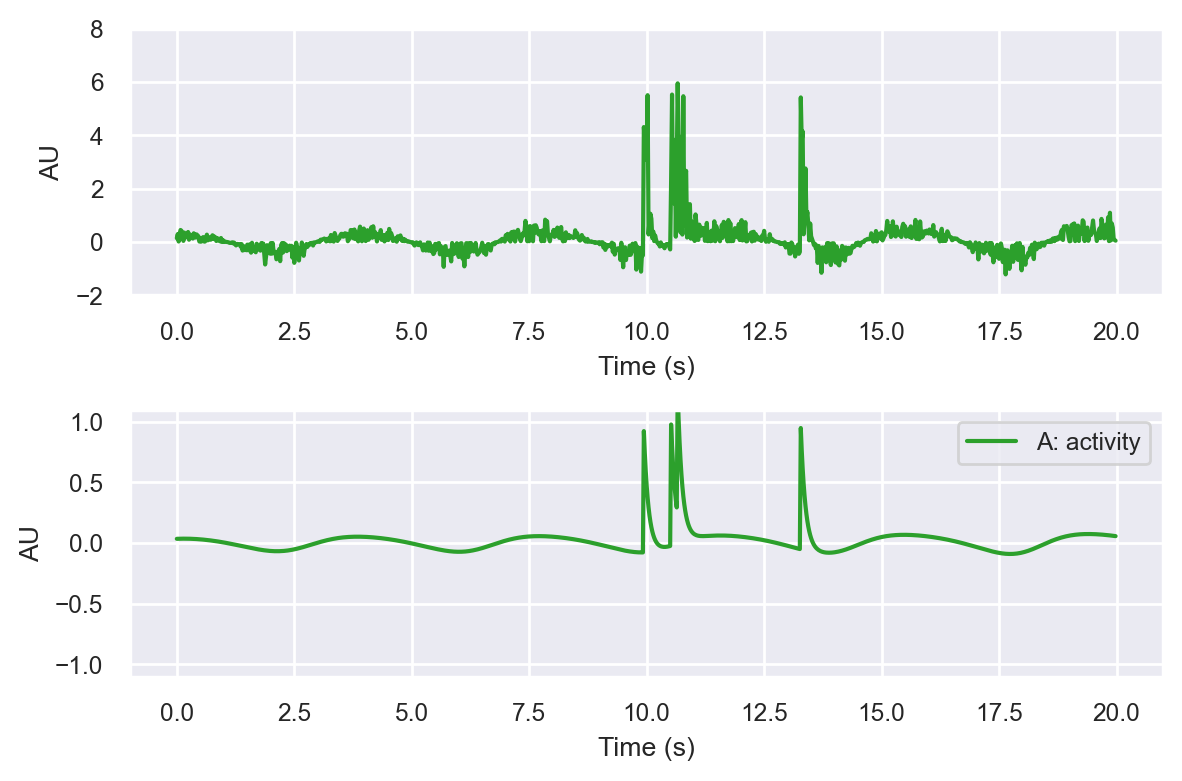

In [12]:
# This section is a check on how well the hardware separates sources
# dims are tjl for O
cmap = plt.get_cmap('tab10', lut=8)
for i,j,wavelength in [(0,2,510), (1,3,525), (2,4,591)]:
    # find index for closest wavelength
    l = np.argmin(np.abs(sim.L_arr - wavelength))
    print(l)

    f, ax = plt.subplots(2, figsize=(6, 4))
    ax[0].plot(sim.T_arr, dat['O'][:, j, l], c=cmap(i), label=f'{sim.L_arr[l]:0.2f}')
    ax[0].set(xlabel='Time (s)', ylabel='AU', ylim=[-2, 8])
    ax[1].plot(sim.T_arr, dat['A'][:, i], c=cmap(i), label='A: activity')
    ax[1].set(xlabel='Time (s)', ylabel='AU', ylim=[-1.1, 1.1])
    plt.tight_layout()
    plt.legend()
    plt.show()


In [13]:
#sim.T_arr, 
T, J, L = np.shape(dat['O'])

In [14]:
def coef_fn(x,y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x)*np.std(y) + 1e-10)
    return c

In [15]:
coef_list = []
for j in range(J):
    coef = np.empty((L,L))
    coef[:] = np.nan
    for l1 in range(L):
        for l2 in range(l1,L):
            coef[l1,l2] = coef_fn(dat['O'][:,j,l1], dat['O'][:,j,l2])
    coef_list.append(coef)

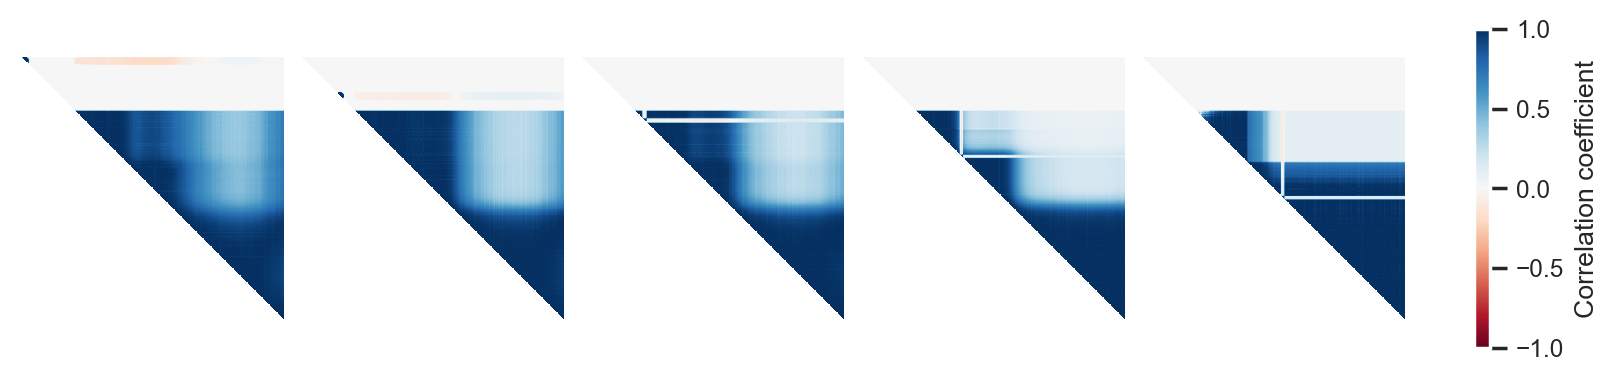

In [16]:
# signals are correlated across wavelengths
# this is shown for each laser-channel
# a distinct pattern is also observed at the laser emission wavelength
# the block diagonal arises from the signal being dominated by the different sensors in different spectral blocks
cmap = plt.get_cmap('RdBu').copy()
cmap.set_bad(color='w', alpha=1.)
f, ax = plt.subplots(1, J, figsize=(8, 8*J), constrained_layout=True)
for j in range(J):
    i = ax[j].imshow(coef_list[j], vmin=-1, vmax=1, aspect=1, cmap=cmap)
    ax[j].axis('off')
    ax[j].grid(False)
f.colorbar(i, ax=ax[:], location='right', shrink=0.04,
           label='Correlation coefficient')
plt.show()

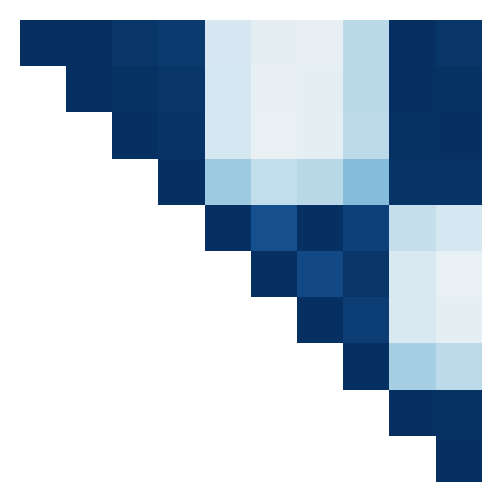

In [17]:
cmap = plt.get_cmap('RdBu').copy()
cmap.set_bad(color='w', alpha=1.)
f, ax = plt.subplots(1,1,figsize=(3,3))
i = ax.imshow(coef_list[4][155:165,155:165], vmin=-1, vmax=1, aspect=1, cmap=cmap)
ax.axis('off')
ax.grid(False)


[555.51839465 556.52173913 557.52508361 558.52842809 559.53177258
 560.53511706 561.53846154 562.54180602 563.5451505  564.54849498]

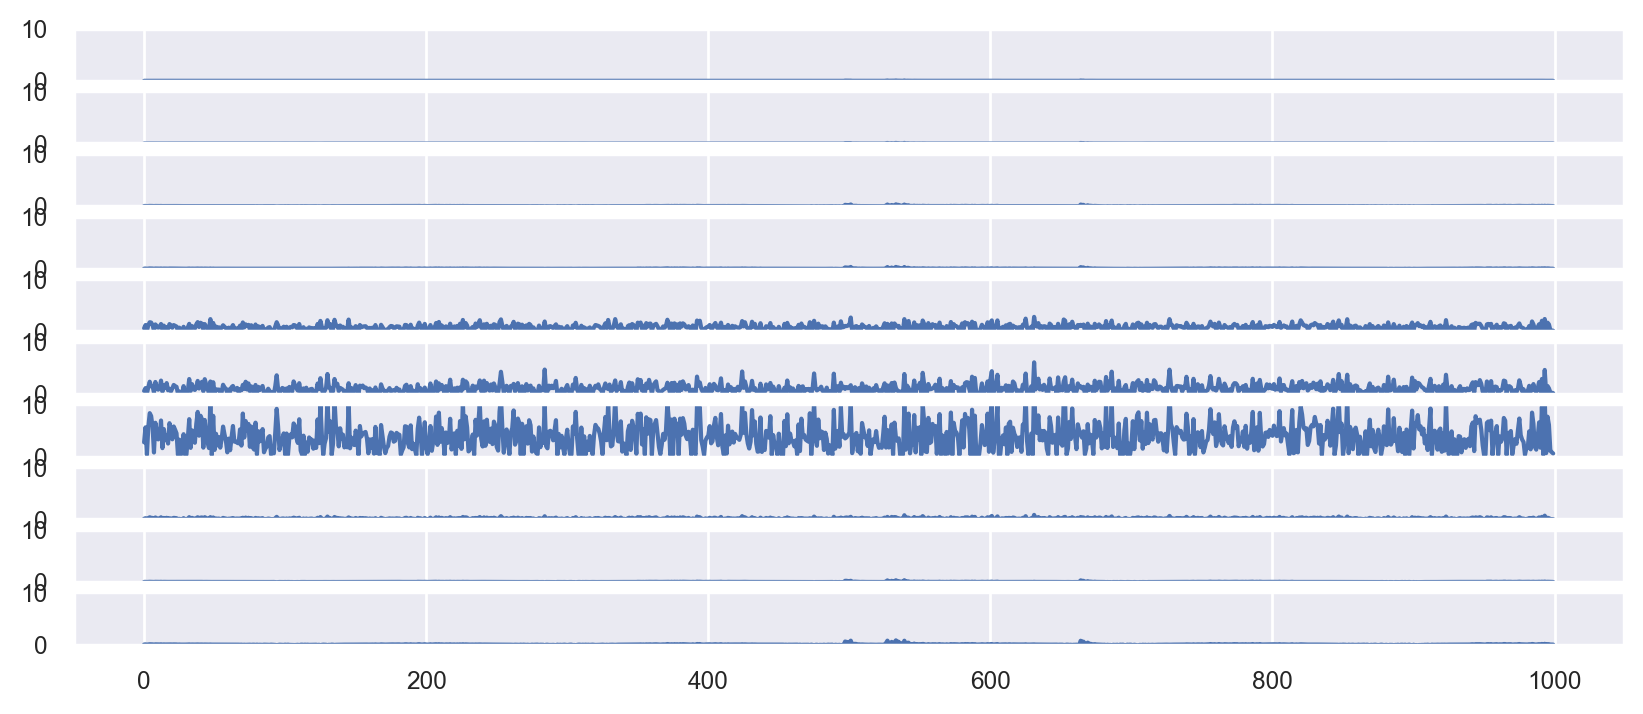

In [18]:
# zooming in to inspect the pattern around laser emission wavelengths
pprint(sim.L_arr[155:165])
f, ax = plt.subplots(10,1,figsize=(10,4))
for i,l in enumerate(range(155,165)):
    ax[i].plot(dat['O'][:,4,l])
    ax[i].set(ylim=(0,10))
plt.show()